In [1]:
!pip install git+https://github.com/LBNL-ETA/FMI-MLC

  Cloning https://github.com/LBNL-ETA/FMI-MLC to /tmp/pip-req-build-m_i0gfck
  Running command git clone --filter=blob:none --quiet https://github.com/LBNL-ETA/FMI-MLC /tmp/pip-req-build-m_i0gfck
  Resolved https://github.com/LBNL-ETA/FMI-MLC to commit c24be53fff0dc27b4df28ee992c4f70d03acf7d1
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [50]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

mpl.rcParams['figure.dpi'] = 72


# Get the directory where the current script is located
root = os.getcwd()

# Add the parent directory to the sys.path
sys.path.append(os.path.join(root, '..'))
print(root)


from fmi_mlc import fmi_gym
from fmi_mlc import get_default_parameter

/root/.vscode-server/bin/eaa41d57266683296de7d118f574d0c2652e1fc4


In [161]:
# Define global parameters
R = 8.314
F = 1.602176634 *10**(-19)
M = 5000
m = 1
V_tn = 1.482
T_amb = 273.15 + 23.5
K=1.4

# Electrolyzer parameters
eta_EL = 0.6
eta_F_EL = 0.95 # Faradaic efficiency
P_EL_STB = 285.7
P_EL_nom = 5000
P_EL_max = 5000
P_EL_min = 0.1 * P_EL_max
r_EL = 4500 # 20 W/s or depeds on t_s
C_rep_EL = 0.27*1.55*10**(-3)  # replacement cost (euro/W) - to be multiplied by installed power in W P_EL_nom
N_H_EL = 40000     # number of hours
C_OM_EL = 0.002    # O&M cost (euro/h)
alpha_EL = 1000 * (C_rep_EL * P_EL_nom /N_H_EL + C_OM_EL) # (euro/Wh * W + euro/h)

# Electrolyzer auxiliaries parameters


# Fuel cell parameters
eta_FC = 0.4
eta_F_FC = 0.95 # Faradaic efficiency
P_FC_STB = 100
P_FC_nom = 5000
P_FC_max = 4300
P_FC_min = 300
r_FC = 5 * t_s # 5 W/s if t_s < 15min, otherwise = P_FC_max  
C_rep_FC = 0.27*1.55*10**(-3)  # replacement cost for the fuel cell (euro/W) - to be multiplied by installed power in W P_EL_nom
N_H_FC = 40000     # number of hours for the fuel cell (h)
C_OM_FC = 0.01    # O&M cost for the fuel cell (euro/h)
alpha_FC = 1000 * (C_rep_FC * P_FC_nom /N_H_FC + C_OM_FC) # (euro/Wh * W + euro/h)

# Fuel cell auxiliaries parameters


# Hydrogen storage parameters
LOH_min = 0.1 # (1)
LOH_max = 0.99 # (1)
C_max = 5158.1*10**6 # (J), for LHV = 119.96 MJ/kg

# Battery parameters
E_battery_nom = 5000 # (Wh)
C_battery_inv = 0.37  # investment cost for the battery (euro/Wh)
N_battery_cycles = 4000  # number of battery cycles
P_battery_nom = 5000 # (W)
c_battery = C_battery_inv * E_battery_nom / (2 * N_battery_cycles * P_battery_nom) # (euro/W)
eta_batt_ch = 0.98 # (1)
eta_batt_disch = 0.98 # (1)
SOE_min = 500 # (Wh)
SOE_max = 4500 # (Wh)

# Grid arameters
P_grid_max = 10000 # (W)

In [29]:
# example controller - inputs: SOE battery, SOC hess (PV and load and power prices profiles are read from before)
def control(ctrl_inputs, pv_slice, load_slice):
    # Initialize action dictionary
    action = {
        'P_battery': 0,
        'P_FC_sys': 0,
        'P_EL_sys': 0,
        'state_FC': 0,
        'state_EL': 0
    }

    # Extract necessary information from inputs
    soe_battery = ctrl_inputs[3]  # Adjust index based on actual state structure
    soc_hess = ctrl_inputs[5]     # Adjust index based on actual state structure

    # Basic control logic
    if soe_battery < 1000:
        action['P_battery'] = 1000  # Charge battery
    elif soe_battery > 2000:
        action['P_battery'] = -1000  # Discharge battery
    else:
        action['P_battery'] = 0  # Maintain current state

    if load_slice[0] + pv_slice[0] >= 0:
        action['P_EL_sys'] = 0     # No electrolyzer operation
        action['state_EL'] = 0     # EL OFF
        action['P_FC_sys'] = load_slice[0] + pv_slice[0]  # Increase fuel cell operation
        action['state_FC'] = 2
    else:
        action['P_EL_sys'] = - load_slice[0] - pv_slice[0]  # Increase electrolyzer operation
        action['state_EL'] = 2     # EL ON
        action['P_FC_sys'] = 0     # No fuel cell output
        action['state_FC'] = 0     # FC OFF

    # Convert action dictionary to a list of values
    action_list = list(action.values())
    print("Computed action list:", action_list)

    return action_list

In [30]:
def optimizer(T, t_s, c_el, pv, load, SOE_initial, LOH_initial): 
    # adapt inputs: T (horizon of simulation), ts (sampling time), SOE_battery, LOH_hess, pv, load, c_el (electricity prices)
    # states: SOE_battery, LOH_hess
    # inputs to FMU: P_battery, P_FC_sys (start with P_FC), P_El_sys (start with P_El), state_FC, state_EL

    # ITERATION 1: no auxiliaries, no thermal model, no transitions, no STB state
    # inputs variables in MPC: P_battery_disch, P_battery_ch, P_grid, P_FC, delta_ON_FC, delta_OFF_FC, P_EL, delta_ON_EL, delta_OFF_EL
    # P_batt = P_batt, ch - P_batt,disch - we assume unitary efficiency 
    
    
    # Access global parameters
    global P_grid_max, P_battery_nom, eta_batt_ch, eta_batt_disch, SOE_min, SOE_max
    global LOH_min, LOH_max, C_max, eta_El, eta_FC, P_EL_min, P_EL_max, P_EL_STB, P_FC_min, P_FC_max, P_FC_STB, r_EL, r_FC
    global alpha_EL, alpha_FC, c_battery

    N = int(T // t_s)
    
    # Initialize
    import casadi as ca
    opti = ca.Opti()

    # -----------------------------
    # Variables and solver
    # -----------------------------

    SOE = opti.variable(1, N+1)  # state
    LOH = opti.variable(1, N+1)  # state
    P_batt = opti.variable(1, N)  # input
    P_grid_sale = opti.variable(1, N)        # input 
    P_grid_pchs = opti.variable(1, N)        # input 
    P_FC = opti.variable(1, N)          # input
    delta_ON_FC = opti.variable(1, N)   # binary input
    delta_OFF_FC = opti.variable(1, N)  # binary input
    P_EL = opti.variable(1, N)          # input
    delta_ON_EL = opti.variable(1, N)   # binary input
    delta_OFF_EL = opti.variable(1, N)  # binary input

    # delta_i are discrete variables (binary)
    discrete_var = [0]*(N+1) + [0]*(N+1) + [0]*N + [0]*N + [0]*N + [0]*N + [1]*N + [1]*N + [0]*N + [1]*N + [1]*N

    # Solver
    opti.solver('bonmin', {'discrete': discrete_var, 'bonmin.tol': 1e-4, 'bonmin.print_level': 0, 'print_time': 0})

    # -----------------------------
    # Constraints
    # -----------------------------

    # Initial storage level
    opti.subject_to(SOE[0] == SOE_initial)
    opti.subject_to(LOH[0] == LOH_initial)

    # Constraints at every time step
    for t in range(N):

            # Bounds on grid
            opti.subject_to(pv[t] + P_grid_pchs[t] + P_FC[t] == load[t] + P_grid_sale[t] + P_batt[t] + P_EL[t])
            opti.subject_to(P_grid_sale[t]>=0)
            opti.subject_to(P_grid_sale[t]<=P_grid_max)
            opti.subject_to(P_grid_pchs[t]>=0)
            opti.subject_to(P_grid_pchs[t]<=P_grid_max)

            # Bounds on battery and SOE
            opti.subject_to(P_batt[t]>=0)
            opti.subject_to(P_batt[t]<=0.9 * P_battery_nom)
        
            opti.subject_to(SOE[t+1] == SOE[t] + P_batt[t] * t_s/3600)
            opti.subject_to(SOE[t] >= SOE_min)
            opti.subject_to(SOE[t] <= SOE_max)
            
            # Bounds on hydrogen storage 
            opti.subject_to(LOH[t+1] == LOH[t] + (P_EL[t] * eta_EL - P_FC[t]/eta_FC) * t_s /C_max)
            opti.subject_to(LOH[t] >= LOH_min)
            opti.subject_to(LOH[t] <= LOH_max)                

            # Constraints on electrolyzer
            # Bounds when ON                
            opti.subject_to(P_EL[t] >= delta_ON_EL[t] * P_EL_min)
            opti.subject_to(P_EL[t] <= delta_ON_EL[t] * P_EL_max)
        
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_EL[t+1] - P_EL[t] <= r_EL)
                opti.subject_to(P_EL[t] - P_EL[t+1] <= r_EL)
                            
            # Constraints on fuel cell
            # Bounds when ON
            opti.subject_to(P_FC[t] >= delta_ON_FC[t] * P_FC_min)
            opti.subject_to(P_FC[t] <= delta_ON_FC[t] * P_FC_max)
            
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_FC[t+1] - P_FC[t] <= r_FC)
                opti.subject_to(P_FC[t] - P_FC[t+1] <= r_FC)
                            
            # States                
            opti.subject_to(delta_ON_EL[t] + delta_OFF_EL[t] == 1)
            opti.subject_to(delta_ON_FC[t] + delta_OFF_FC[t] == 1)


                            
            # Bilinear to linear


    # -----------------------------
    # Objective
    # -----------------------------

    obj = sum(alpha_EL * t_s/3600 * delta_ON_EL[t] + alpha_FC * t_s/3600 * delta_ON_FC[t] + c_battery * ca.fabs(P_batt[t]) + (c_el[t] * P_grid_pchs[t] - 0 * c_el[t] * P_grid_sale[t]) * t_s/3600 for t in range(N))
    opti.minimize(obj)
    
    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sol = opti.solve()
    
    SOE_opt = sol.value(SOE)
    LOH_opt = sol.value(LOH)
    P_batt_opt = sol.value(P_batt)
    P_grid_sale_opt = sol.value(P_grid_sale)
    P_grid_pchs_opt = sol.value(P_grid_pchs)
    P_FC_opt = sol.value(P_FC)  
    delta_ON_FC_opt = sol.value(delta_ON_FC)
    delta_OFF_FC_opt = sol.value(delta_OFF_FC)
    P_EL_opt = sol.value(P_EL)
    delta_ON_EL_opt = sol.value(delta_ON_EL)
    delta_OFF_EL_opt = sol.value(delta_OFF_EL)

    obj_opt = round(sol.value(obj), 2)

    return SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_OFF_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_OFF_FC_opt, P_FC_opt, obj_opt
        

In [31]:
def ctrl_postprocessor(delta_ON_EL, delta_OFF_EL, delta_ON_FC, delta_OFF_FC, P_FC, P_EL, P_grid_pchs, P_grid_sale):
    state_EL = []
    state_FC = []
    P_battery = []
    P_grid = []

    # Loop over each time step
    for i in range(len(delta_ON_EL)):
        # Determine the state of the electrolyzer
        if delta_ON_EL[i] == 1:
            state_EL.append(2)  # ON state
        elif delta_OFF_EL[i] == 1:
            state_EL.append(0)  # OFF state
        else:
            state_EL.append(1)  # Standby state

        # Determine the state of the fuel cell
        if delta_ON_FC[i] == 1:
            state_FC.append(2)  # ON state
        elif delta_OFF_FC[i] == 1:
            state_FC.append(0)  # OFF state
        else:
            state_FC.append(1)  # Standby state

        # Calculate the net grid power for each time step
        P_grid.append(P_grid_sale[i] - P_grid_pchs[i])

    return np.array(P_FC), np.array(P_EL), np.array(state_FC), np.array(state_EL), np.array(P_grid)


In [32]:
def MPC(states, c_el_slice, pv_slice, load_slice, T, t_s):

    # Debugging: Print out the inputs to ensure they are correct
    print(f"Running MPC with horizon {T}")
    print(f"c_el_slice: {c_el_slice}")
    print(f"pv_slice: {pv_slice}")
    print(f"load_slice: {load_slice}") 
    
    # Initialize action dictionary
    action = {
        'P_battery': 0,
        'P_FC_sys': 0,
        'P_EL_sys': 0,
        'state_FC': 0,
        'state_EL': 0
    }

    tolerance = 1*10**(-2)
    
    # Extract necessary information from inputs
    SOE = states[2]  # Adjust index based on actual state structure
    LOH = states[4]    
    #print(f"SOE initial: {SOE}")
    #print(f"LOH initial: {LOH}")
    
    SOE_opt, LOH_opt, P_batt, P_grid_sale, P_grid_pchs, delta_ON_EL, delta_OFF_EL, P_EL, delta_ON_FC, delta_OFF_FC, P_FC, obj_opt = optimizer(T, t_s, c_el_slice, pv_slice, load_slice, SOE, LOH)
    
    
    # Compute values for action['P_battery'], action['P_EL_sys'], action['P_FC_sys'], action['state_EL'] and action['state_FC']
    P_FC, P_EL, state_FC, state_EL, P_grid = ctrl_postprocessor(delta_ON_EL, delta_OFF_EL, delta_ON_FC, delta_OFF_FC, P_FC, P_EL, P_grid_pchs, P_grid_sale)

    # Update action dictionary with the first value of each vector
    action['P_battery'] = P_batt[0]
    action['P_FC_sys'] = P_FC[0]
    action['P_EL_sys'] = P_EL[0]
    action['state_FC'] = state_FC[0]
    action['state_EL'] = state_EL[0]

    for key in ['P_battery', 'P_EL_sys', 'P_FC_sys']:
        if abs(action[key]) < tolerance:
            action[key] = 0
     
    # Convert action dictionary to a list of values
    action_list = list(action.values())
    # Round each action to 2 decimal places
    action_list = [round(a, 2) for a in action_list]

     # Create the observation DataFrame: take 2nd element of SOE and LOH as first elemet is the initial state given by the FMU
    observation = pd.DataFrame({
        'SOE': [SOE_opt[1]],
        'LOH': [LOH_opt[1]],
        'P_grid': [P_grid[0]], 
        'Objective': [obj_opt]
    })
    
    return action_list, observation

In [166]:
# class controller
class controller:
    def __init__(self, c_el, pv, load, T, t_s):
        self.c_el = c_el
        self.pv = pv
        self.load = load
        self.T = int(T // t_s)
        self.t_s = t_s
        self.iteration = 0

    def do_step(self, state):
        k = self.iteration 

        print("c_el before slicing:", self.c_el)

        # Extract the relevant slice from the pv and load vectors
        c_el_slice = self.c_el[k:k + self.T]
        pv_slice = self.pv[k:k + self.T]
        load_slice = self.load[k:k + self.T]

        print("c_el_slice:", c_el_slice)

        # If we're at the end and slices are too short wrto initial time horizon, pad with 0
        if len(pv_slice) < self.T:
            pv_slice = np.pad(pv_slice, (0, self.T - len(pv_slice)), 'constant', constant_values=0)
            load_slice = np.pad(load_slice, (0, self.T - len(load_slice)), 'constant', constant_values=0)
            c_el_slice = np.pad(c_el_slice, (0, self.T - len(c_el_slice)), 'constant', constant_values=0)


        # Controller logic using state, pv_slice, and load_slice
        #action = control(state, pv_slice, load_slice) # replace control() by MPC() when MPC is ready
        action, observation = MPC(state, c_el_slice, pv_slice, load_slice, T, t_s)
        
        # Increment the iteration counter
        self.iteration += 1
        
        return action, observation
        


# fmi_gym parameter initialization
T = 2*60*60  # horizon time (at each iteration, optimization horizon - can be different than simulation duration
t_s = 15*60  # Time step size in seconds: ts = 1h -> for not losing too much on transitions for HESS, ideally ts should be smaller or equal to tau_CLD
N = int(T//t_s) # Number of ieration in 1 optimization

parameter = {}

parameter['seed'] = 1
parameter['store_data'] = True
# parameter['postprocessor'] = microgrid_postprocessor 
# parameter['preprocessor'] = microgrid_preprocessor 


# fmu parameter initialization
dtype = np.float64
parameter['fmu_step_size'] = t_s
parameter['fmu_path'] = os.path.join(root, '/home/alienor/Documents/hess/MPC-FMU/FMU/H2Microgrid_0TransiEnt_HybridMicrogrid_H2Microgrid_0HP.fmu') #/home/alienor is the way to access my folders via the container
print(f"Root directory: {root}")
print("FMU Path:", parameter['fmu_path'])

parameter['fmu_start_time'] = 100*24*60*60 + 10*60*60
parameter['fmu_warmup_time'] = 0*60*60
parameter['fmu_final_time'] = 100*24*60*60 + 16*60*60
# if you need to overwrite used weather file in model. Same for load file.
#parameter['fmu_param'] = {'weaDat.weather_file': '/home/alienor/Documents/hess/H2Microgrid_TransiEnt/Resources/weather/USA_CA_Los.Angeles.Intl.AP.722950_TMY3.mos'}

# find a way to overwrite initalization of battery SOC and HESS SOC

# data exchange parameter
parameter['action_names'] = ['P_set_battery', 'P_set_FC', 'P_set_EL', 'state_FC', 'state_EL' ]
parameter['action_min'] = np.array([-1e4, 0, 0, 0, 0], dtype=dtype) # can ignore this, can set to [-1e3] * len(action_names)
parameter['action_max'] = np.array([1e4, 1e4, 1e4, 0, 0], dtype=dtype) 
parameter['observation_names'] = ['P_PV', 'P_load', 'SOE_battery', 'P_battery', 'LOH', 'P_EL', 'P_FC']

env = fmi_gym(parameter)


Root directory: /root/.vscode-server/bin/eaa41d57266683296de7d118f574d0c2652e1fc4
FMU Path: /home/alienor/Documents/hess/MPC-FMU/FMU/H2Microgrid_0TransiEnt_HybridMicrogrid_H2Microgrid_0HP.fmu


In [155]:
# Initialize the environment 
# Dry run to read PV and load profiles on entire simulation, and use them as forecasts
done = False
state = env.reset()

# Run the simulation
while not done:
    action = env.action_space.sample() # random test without actions computed by controller --> good dry run to read PV and load profiles!
    state, reward, done, info = env.step(action)
    
    if done:
        dry = env.data.copy(deep=True)
        state = env.reset()
env.close()


  Tag: simulation.nonlinear[9] during event iteration at time 8.66958e+06.


  Tag: simulation.nonlinear[9] during event iteration at time 8.67198e+06.


  Tag: simulation.nonlinear[9] during event iteration at time 8.67792e+06.


  Tag: simulation.nonlinear[9] during event iteration at time 8.67828e+06.


  Tag: simulation.nonlinear[9] during event iteration at time 8.68062e+06.


  Tag: simulation.nonlinear[9] during event iteration at time 8.68392e+06.


  Tag: simulation.nonlinear[9] during event iteration at time 8.68656e+06.


  Tag: simulation.nonlinear[9] during event iteration at time 8.68716e+06.


  Tag: simulation.nonlinear[9] during event iteration at time 8.69016e+06.



In [157]:
# When timestep is a multiple of 1 hour
dry.index = [pd.to_datetime('2021-01-01') + pd.DateOffset(seconds=ix) for ix in dry.index]


In [158]:
# When timestep is not a multiple of 1 hour
# Reference time
reference_time = pd.to_datetime('2021-01-01')

# Convert Timestamps to seconds
dry.index = (dry.index - reference_time).total_seconds().astype(int)

# Generate the new index
dry.index = [reference_time + pd.DateOffset(seconds=ix) for ix in dry.index]

In [159]:
dry = dry[['time', 'P_PV', 'P_load']]

dry

,time,P_PV,P_load
2021-04-11 08:00:00,8668800.0,3219.037279,11826.289544
2021-04-11 08:15:00,8669700.0,4220.853414,11859.196258
2021-04-11 08:30:00,8670600.0,5081.673984,11859.196258
2021-04-11 08:45:00,8671500.0,6822.731644,11859.196258
2021-04-11 09:00:00,8672400.0,10039.469663,11859.196258
2021-04-11 09:15:00,8673300.0,13552.826995,12220.294078
2021-04-11 09:30:00,8674200.0,15745.205509,12220.294078
2021-04-11 09:45:00,8675100.0,16517.245302,12220.294078
2021-04-11 10:00:00,8676000.0,16901.956368,12220.294078
2021-04-11 10:15:00,8676900.0,16977.515051,12462.693150


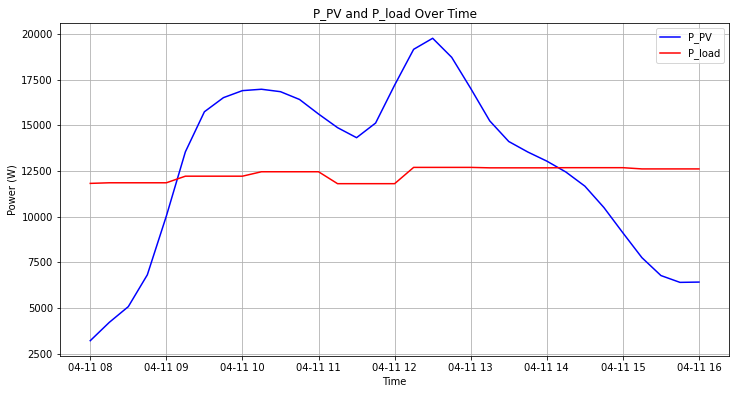

In [160]:
plt.figure(figsize=(12, 6))

plt.plot(dry.index, dry['P_PV'], label='P_PV', color='blue')
plt.plot(dry.index, dry['P_load'], label='P_load', color='red')

plt.title('P_PV and P_load Over Time')
plt.xlabel('Time')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True)
plt.show()

In [167]:
# Assuming dry['P_PV'] and dry['P_load'] are our pv and load vectors + random cost vector
#c_el = np.array([0.28*10**(-3), 0.28*10**(-3), 0.4*10**(-3), 0.35*10**(-3),  0.35*10**(-3), 0.33*10**(-3), 0.25*10**(-3), 0.28*10**(-3), 0.22*10**(-3), 0.28*10**(-3), 0.29*10**(-3) ])  # Electricity prices in euro/Wh - around 0.3 euro/kWh
c_el = np.random.uniform(0.2 * 10**(-3), 0.4 * 10**(-3), N+2)

pv = dry['P_PV'].values
load = dry['P_load'].values

# Initialize an empty list to store observations
observations_list = []

# Create an instance of the controller with pv and load vectors
ctrl = controller(c_el, pv, load, T, t_s)

# Run the simulation
done = False
state = env.reset()

while not done:
    # Assuming SOE_battery is at index 3 and SOC_HESS is at index 5 in the state array
    soe_battery = state[2]  # Adjust index based on actual structure
    loh = state[4]    # using state(k-1) and data(k-1) to compute action(k-1) which is applied in k - data must be shifted to k in results df
    
    # Print SOE_battery and SOC_HESS at each iteration
    print(f"Iteration {ctrl.iteration}: SOE = {soe_battery}, LOH = {loh}")
    

    # Get action using the do_step method
    action, observation = ctrl.do_step(state)
    
    # Print the action to verify
    print("Action computed from the controller:", action)

    # Take a step in the environment using the computed action
    state, reward, done, info = env.step(action)

    print(f"States for next iteration= {state}, Reward: {reward}, Done? {done},  Info: {info} ")
    
    # Append the current observation to the list
    observations_list.append(observation)
    
    
    if done:
        res = env.data.copy(deep=True)
        state = env.reset()

env.close()


In [145]:
# When timestep is a multiple of 1 hour
res.index = [pd.to_datetime('2021-01-01') + pd.DateOffset(seconds=ix) for ix in res.index]

In [146]:
# When timestep is not a multiple of 1 hour
# Reference time
reference_time = pd.to_datetime('2021-01-01')

# Convert Timestamps to seconds
res.index = (res.index - reference_time).total_seconds().astype(int)

# Generate the new index
res.index = [reference_time + pd.DateOffset(seconds=ix) for ix in res.index]

# Shift the 'P_PV' and 'P_load' columns down by 1 row, filling the first value with 0
res['P_PV'] = res['P_PV'].shift(1, fill_value=0)
res['P_load'] = res['P_load'].shift(1, fill_value=0)

In [147]:
res

,time,P_set_battery,P_set_FC,P_set_EL,state_FC,state_EL,P_FC,LOH,P_battery,P_PV,SOE_battery,P_EL,P_load,reward
2021-04-11 03:00:00,8650800.0,0,0.00,0,0,0,0.00,0.500000,0.0,0.000000,2500.0,0.0,0.000000,-1
2021-04-11 04:00:00,8654400.0,0,4300.00,0,2,0,-4300.00,0.485563,0.0,0.000000,2500.0,0.0,4778.024131,-1
2021-04-11 05:00:00,8658000.0,0,4300.00,0,2,0,-4300.00,0.471448,0.0,0.000000,2500.0,0.0,4778.024131,-1
2021-04-11 06:00:00,8661600.0,0,4300.00,0,2,0,-4300.00,0.457518,0.0,45.341415,2500.0,0.0,5053.026812,-1
2021-04-11 07:00:00,8665200.0,0,4300.00,0,2,0,-4300.00,0.443772,0.0,680.162594,2500.0,0.0,5844.880695,-1
2021-04-11 08:00:00,8668800.0,0,4249.38,0,2,0,-4249.38,0.430418,0.0,1542.187284,2500.0,0.0,5740.890593,-1


In [148]:
# Concatenate all observations into a single DataFrame
obs_raw = pd.concat(observations_list, ignore_index=True)

obs_raw.index = [pd.to_datetime('2021-01-01') + pd.DateOffset(hours=ix) for ix in obs_raw.index]

In [149]:
# Step 1: Create a new DataFrame for the first row
initial_row = pd.DataFrame({
    'SOE': [res['SOE_battery'].iloc[0]],
    'LOH': [res['LOH'].iloc[0]],
    'Objective': 0,
    'P_grid': 0,
}, index=[obs_raw.index[0]])


# Step 2: Concatenate the new row with the shifted DataFrame
obs = pd.concat([initial_row, obs_raw], ignore_index=False)

# Step 3: Reset the index if needed to maintain consistency
obs.index = res.index


In [150]:
obs

,SOE,LOH,Objective,P_grid
2021-04-11 03:00:00,2500.0,0.500000,0.00,0.000000
2021-04-11 04:00:00,2500.0,0.492497,30.71,-478.024131
2021-04-11 05:00:00,2500.0,0.478060,30.88,-478.024131
2021-04-11 06:00:00,2500.0,0.463945,30.74,-707.685397
2021-04-11 07:00:00,2500.0,0.450015,40.51,-864.718101
2021-04-11 08:00:00,2500.0,0.436358,30.16,50.679295


In [151]:
res['P_PV'] + res['P_FC'] - obs['P_grid'] - res['P_EL'] - res['P_battery'] - res['P_load'] 

2021-04-11 03:00:00       0.000000
2021-04-11 04:00:00   -8600.000000
2021-04-11 05:00:00   -8600.000000
2021-04-11 06:00:00   -8600.000000
2021-04-11 07:00:00   -8600.000000
2021-04-11 08:00:00   -8498.762604
dtype: float64

### Plot 

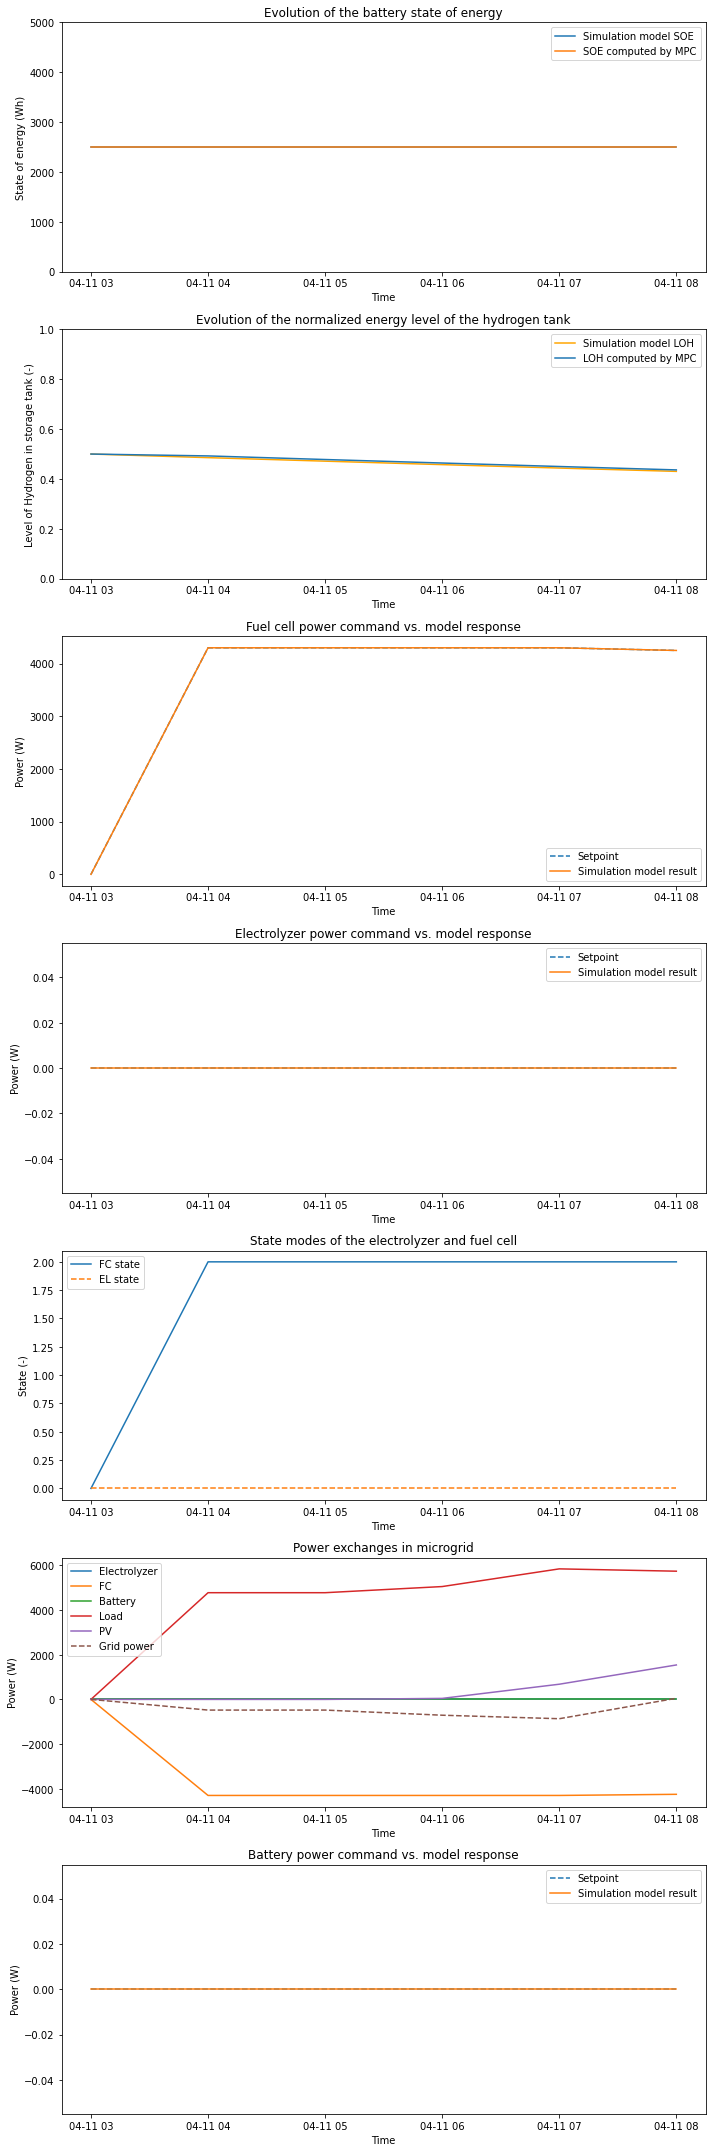

In [153]:
import matplotlib.pyplot as plt

# Assuming the 'res' DataFrame is already loaded

# Create subplots
fig, axs = plt.subplots(7, 1, figsize=(10, 30))

# Plot SOE_battery
axs[0].plot(res['SOE_battery'], label='Simulation model SOE')
axs[0].plot(obs['SOE'], label='SOE computed by MPC')
axs[0].set_title('Evolution of the battery state of energy')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('State of energy (Wh)')
axs[0].set_ylim(0, 5000)  # Set y-axis limits between 0 and 1
axs[0].legend()

# Plot LOH
axs[1].plot(res['LOH'], label='Simulation model LOH', color='orange')
axs[1].plot(obs['LOH'], label='LOH computed by MPC')
axs[1].set_title('Evolution of the normalized energy level of the hydrogen tank')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Level of Hydrogen in storage tank (-)')
axs[1].set_ylim(0, 1)  # Set y-axis limits between 0 and 1
axs[1].legend()

# Plot P_set_FC vs P_FC
axs[2].plot(res['P_set_FC'], label='Setpoint', linestyle='--')
axs[2].plot(-res['P_FC'], label='Simulation model result')
axs[2].set_title('Fuel cell power command vs. model response')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Power (W)')
axs[2].legend()

# Plot P_set_EL vs P_EL
axs[3].plot(res['P_set_EL'], label='Setpoint', linestyle='--')
axs[3].plot(res['P_EL'], label='Simulation model result')
axs[3].set_title('Electrolyzer power command vs. model response')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Power (W)')
axs[3].legend()

# Plot state_FC and state_EL
axs[4].plot(res['state_FC'], label='FC state')
axs[4].plot(res['state_EL'], label='EL state', linestyle='--')
axs[4].set_title('State modes of the electrolyzer and fuel cell')
axs[4].set_xlabel('Time')
axs[4].set_ylabel('State (-)')
axs[4].legend()

# Plot P_set_battery vs P_battery
axs[6].plot(res['P_set_battery'], label='Setpoint', linestyle='--')
axs[6].plot(res['P_battery'], label='Simulation model result')
axs[6].set_title('Battery power command vs. model response')
axs[6].set_xlabel('Time')
axs[6].set_ylabel('Power (W)')
axs[6].legend()

# Plot Power balance with P_EL, P_FC, P_battery, P_load, P_PV, P_grid
axs[5].plot(res['P_EL'], label='Electrolyzer')
axs[5].plot(res['P_FC'], label='FC')
axs[5].plot(res['P_battery'], label='Battery')
axs[5].plot(res['P_load'], label='Load')
axs[5].plot(res['P_PV'], label='PV')
axs[5].plot(obs['P_grid'], label='Grid power', linestyle='--')
axs[5].set_title('Power exchanges in microgrid')
axs[5].set_xlabel('Time')
axs[5].set_ylabel('Power (W)')
axs[5].legend()


# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=False)
axs = axs.ravel()

# Plot difference between P_PV and P_load
dry['P_load'].plot(ax=axs[0])
axs[0].set_ylabel('Power [W]')
axs[0].set_title('Load')

# Plot P_EL and P_FC
dry['P_PV'].plot(ax=axs[1])
axs[1].set_ylabel('Power [W]')
axs[1].set_title('Solar power')

# Show plot
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=False)
axs = axs.ravel()
res[['P_set_battery', 'P_battery', 'P_set_FC', 'P_FC', 'P_set_EL', 'P_EL', 'P_PV', 'P_load']].plot(ax=axs[0])
axs[0].set_ylabel('Power [W]')
res[['state_FC', 'state_EL']].plot(ax=axs[1])
axs[1].set_ylabel('Modes/states')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=False)
axs = axs.ravel()
res[['P_battery']].plot(ax=axs[0])
axs[0].set_ylabel('Power [W]')
res[['SOE_battery']].plot(ax=axs[1])
axs[1].set_ylabel('Modes/states')
plt.show()

In [ ]:
obs_exc_las = obs.iloc[:-1]

# Plotting the Objective over time (excluding the last time point)
plt.figure(figsize=(10, 6))
plt.plot(obs['Objective'], marker='o', linestyle='-', color='blue', label='Objective')
plt.title('Operating cost Over Time Horizon ')
plt.xlabel('Time')
plt.ylabel('Cost [EUR] ')
plt.grid(True)
plt.legend()
plt.show()